In [1]:
import numpy as np;import pandas as pd;from scipy.special import comb
import math
def cumulative_error(n_partes,error):
    K_inicio=int(math.ceil(n_partes/2))
    cumlativo=0
    for i in range(K_inicio,n_partes+1):
        cumlativo+=comb(n_partes,i)*error**i*(1-error)**(n_partes-i)
    return cumlativo
        


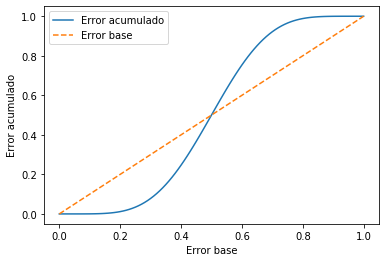

In [2]:
import matplotlib.pyplot as plt
error_range = np.arange(0.0, 1.01, 0.01)
error_acumulado=[cumulative_error(11,error) for error in error_range]
plt.plot(error_range,error_acumulado,label='Error acumulado')
plt.plot(error_range,error_range,label='Error base',linestyle='--')
plt.xlabel('Error base');plt.ylabel('Error acumulado')
plt.legend()


#### De la gráfica anterior se observa que el conjunto de clasificadores tiene un mejor rendimiento cuando cada uno de los clasificadores individuales poseen un error de clasificación inferior al 50%. Por encima de este valor el rendimiento conjunto es inferior al de un clasficador base. 

In [3]:
from sklearn.datasets import load_iris;from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split;from sklearn.preprocessing import LabelEncoder
X=load_iris().data[50:,[1,2]]
y=load_iris().target[50:]
y=LabelEncoder().fit_transform(y)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.5,random_state=1,stratify=y)



In [4]:
from sklearn.linear_model import LogisticRegression;from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier;from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score;from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline

estimador1=make_pipeline(StandardScaler(),LogisticRegression(C=0.001,random_state=1))
estimador2=make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=1))
clf2 = DecisionTreeClassifier(max_depth=1,criterion='entropy',random_state=0)
estimadores=[estimador1,estimador2,clf2]
nombres=['LR','KNN','DTC']

for clf,nombre in zip(estimadores,nombres):
    scores=cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,n_jobs=-1,scoring='roc_auc')
    print(f'{nombre}  {np.mean(scores):.2f} +/- {np.std(scores):.2f}')
    
   





LR  0.92 +/- 0.15
KNN  0.85 +/- 0.13
DTC  0.87 +/- 0.18


#### En la celda anterior se puede apresiar la precisión de los estimadores de forma independiente

In [5]:
from VotingML import esemble_models
ensemble=esemble_models(estimadores)
estimadores=[estimador1,estimador2,clf2,ensemble]
nombres=['LR','KNN','DTC','CONJUNTO']

for clf,nombre in zip(estimadores,nombres):
    scores=cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,n_jobs=-1,scoring='roc_auc')
    print(f'{nombre}  {np.mean(scores):.2f} +/- {np.std(scores):.2f}')


LR  0.92 +/- 0.15
KNN  0.85 +/- 0.13
DTC  0.87 +/- 0.18
CONJUNTO  0.98 +/- 0.05


Text(0.5, 1.0, 'Conjunto')

<Figure size 432x288 with 0 Axes>

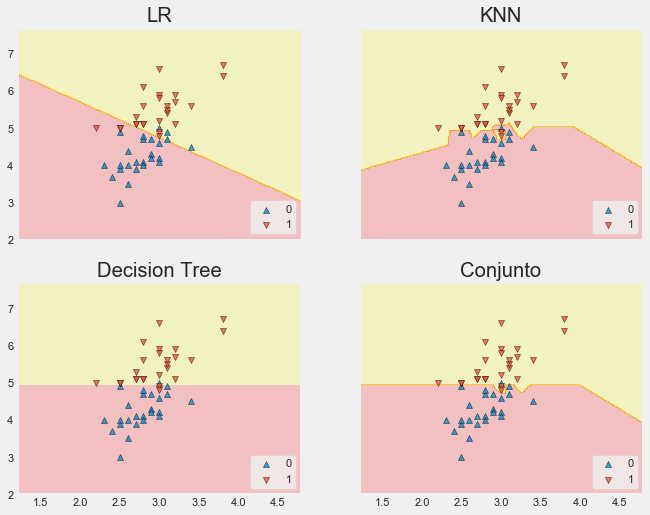

In [6]:
from fronteras import visualizador;import matplotlib.pyplot as plt;import seaborn as sns;sns.set()
plt.style.use('fivethirtyeight')
plt.figure().subplots_adjust(hspace=0.1,wspace=0.1)
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.grid(b=False)
plt.xticks([])
s=StandardScaler()
X_std=s.fit_transform(X_train)
estimador1.fit(X_train,y_train)
estimador2.fit(X_train,y_train)
clf2.fit(X_train,y_train)
visualizador.visualizar_fronteras(X_train,y_train,estimador1)
plt.title('LR')
plt.subplot(2,2,2)
plt.xticks([])
plt.yticks([])
visualizador.visualizar_fronteras(X_train,y_train,estimador2)
plt.title('KNN')
plt.subplot(2,2,3)
visualizador.visualizar_fronteras(X_train,y_train,clf2)
plt.title('Decision Tree')
plt.grid(b=False)
plt.subplot(2,2,4)
ee=ensemble.fit(X_train,y_train)
visualizador.visualizar_fronteras(X_train,y_train,ee)
plt.yticks([])
plt.grid(b=False)
plt.title('Conjunto')



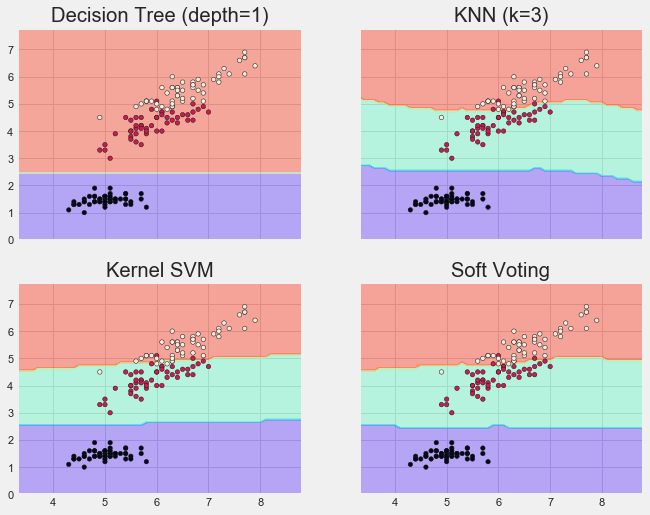

In [7]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=1)
clf2 = KNeighborsClassifier(n_neighbors=3)
clf3 = SVC(gamma=.1, kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                    ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=1)', 'KNN (k=3)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4,cmap='rainbow')
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

In [9]:
grid.best_params_

{'dt__max_depth': 1, 'knn__n_neighbors': 3}